## Тематическая модель на данных Last.fm

Сначала настраиваем и подключаем нужные библиотеки

In [23]:
import os
import sys
HOME = '/home/vovapolu/Projects/'
BIGARTM_PATH = HOME + 'bigartm/'
BIGARTM_BUILD_PATH = BIGARTM_PATH + 'build/'
sys.path.append(os.path.join(BIGARTM_PATH, 'src/python'))
os.environ['ARTM_SHARED_LIBRARY'] = os.path.join(BIGARTM_BUILD_PATH, 'src/artm/libartm.so')

In [24]:
%matplotlib inline
import csv, shutil, uuid, glob, time
import matplotlib.pyplot as plt

import artm.artm_model
from artm.artm_model import *

plays_file = 'usersha1-artmbid-artname-plays.tsv'
batch_path = 'batches' #Папка с батчами
if os.path.exists(batch_path):
    shutil.rmtree(batch_path)

artist_id_to_name = {} #Мапа, переводящая artist_id в имя
artists_idxs = {} #Мапа, переводящая artist_id в номер в батче
artists = [] #Имена артистов в батче

Читаем файл и строим батчи

In [25]:
last_user_id = ''
handled_users = 0

users_to_handle = 5000 #Данные скольких юзеров обрабатываем
users_in_batch = 1000 #Сколько юзеров в батче

batch = None

with open(plays_file, 'rb') as tsvin:
    tsvin = csv.reader(tsvin, delimiter='\t', quoting=csv.QUOTE_NONE)

    field = None

    for row in tsvin:
        
        user_id, artist_id, artist_name, plays = row

        if user_id != last_user_id:
            if handled_users > users_to_handle or handled_users % users_in_batch == 0:
                if batch is not None:
                    for artist in artists:
                        batch.token.append(artist.decode('utf8'))
                    artm.library.Library().SaveBatch(batch, batch_path)
                    artists = []
                    artists_idxs = {}
                batch = artm.messages_pb2.Batch()
                batch.id = str(uuid.uuid4())
            
            if handled_users > users_to_handle:
                break
                        
            item = batch.item.add()
            item.id = handled_users
            field = item.field.add()
            
            last_user_id = user_id
            handled_users += 1
            
        if artist_id not in artist_id_to_name:
            artist_id_to_name[artist_id] = artist_name
        if artist_id not in artists_idxs:
            artists_idxs[artist_id] = len(artists)
            artists.append(artist_name)

        field.token_id.append(artists_idxs[artist_id])
        field.token_count.append(int(plays))

Запускаем BigArtm

Start fitting...
Fitting tooks -80.3 s


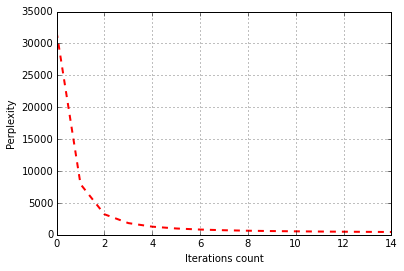

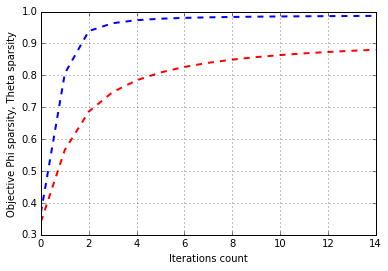

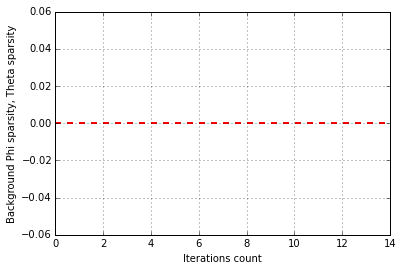

Genres
objective topic 5:  [u'gods of blitz', u'la vela puerca', u'laura marling', u'bromheads jacket', u'fionn regan']
objective topic 6:  [u'dropkick murphys', u'flogging molly', u'the real mckenzies', u'street dogs', u'leona lewis']
objective topic 7:  [u'linkin park', u'evanescence', u'fort minor', u'ko\u042fn', u'bruce faulconer']
objective topic 8:  [u'ac/dc', u'ramones', u'led zeppelin', u'sex pistols', u'the rolling stones']
objective topic 9:  [u'nelly furtado', u'black eyed peas', u'aaliyah', u'sean paul', u'rihanna']
objective topic 10:  [u'die \xc4rzte', u'die toten hosen', u'farin urlaub', u'annihilator', u'freak kitchen']
objective topic 11:  [u'michael bubl\xe9', u'guano apes', u'live', u'rage against the machine', u'tristania']
objective topic 12:  [u'hellogoodbye', u'project 86', u'alter bridge', u'chevelle', u'12 stones']
objective topic 13:  [u'r.e.m.', u'billie the vision & the dancers', u'mando diao', u'camel', u'the disciplines']
objective topic 14:  [u'bad religi

In [37]:
background_topics = []
objective_topics = []
all_topics = []
topic_count = 200
background_topic_count = 5

for i in xrange(topic_count):
    topic_name = ("background" if i < background_topic_count else "objective") + " topic " + str(i)
    all_topics.append(topic_name)
    if i < background_topic_count:
        background_topics.append(topic_name)
    else:
        objective_topics.append(topic_name)
        
model = ArtmModel(topic_names=all_topics)
model.num_processors = 4

# Configure scores

model.scores.add(SparsityPhiScore(name='ObjectiveSparsityPhiScore', topic_names=objective_topics))
model.scores.add(SparsityThetaScore(name='ObjectiveSparsityThetaScore', topic_names=objective_topics))
model.scores.add(SparsityPhiScore(name='BackgroundSparsityPhiScore', topic_names=background_topics))
model.scores.add(SparsityThetaScore(name='BackgroundSparsityThetaScore', topic_names=background_topics))
model.scores.add(SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(PerplexityScore(name='PerplexityScore'))
model.scores.add(TopTokensScore(name='TopTokensScore', num_tokens=20))

# Configure regularizers
model.regularizers.add(SmoothSparsePhiRegularizer(name='ObjectiveSparsePhi', 
                                                  topic_names=objective_topics, tau=-0.1))
model.regularizers.add(SmoothSparseThetaRegularizer(name='ObjectiveSparseTheta', 
                                                    topic_names=objective_topics, tau=-2.0))
model.regularizers.add(SmoothSparsePhiRegularizer(name='BackgroundSparsePhi', 
                                                  topic_names=background_topics, tau=0.1))
model.regularizers.add(SmoothSparseThetaRegularizer(name='BackgroundSparseTheta', 
                                                    topic_names=background_topics, tau=2.0))
model.regularizers.add(DecorrelatorPhiRegularizer(name='DecorrelatorPhi', 
                                                  topic_names=objective_topics, tau=100000.0))

model.initialize(data_path=batch_path)
start = time.clock()
print "Start fitting..."
model.fit_offline(data_path=batch_path, num_collection_passes=15)
print "Fitting tooks %.1f s" % ((finish - start) / 4)

plt.plot(range(model.num_phi_updates), model.scores_info['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()

plt.plot(range(model.num_phi_updates), model.scores_info['ObjectiveSparsityPhiScore'].value, 'b--',
         range(model.num_phi_updates), model.scores_info['ObjectiveSparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Objective Phi sparsity, Theta sparsity')
plt.grid(True)
plt.show()

plt.plot(range(model.num_phi_updates), model.scores_info['BackgroundSparsityPhiScore'].value, 'b--',
         range(model.num_phi_updates), model.scores_info['BackgroundSparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Background Phi sparsity, Theta sparsity')
plt.grid(True)
plt.show()
    
# Visualize top token in each topic and a snippet of theta matrix
print "Genres"
for topic_name in objective_topics:
    print topic_name + ': ',
    print model.scores_info['TopTokensScore'].last_topic_info[topic_name].tokens
print "Background genres"
for topic_name in background_topics:
    print topic_name + ': ',
    print model.scores_info['TopTokensScore'].last_topic_info[topic_name].tokens

In [40]:
main_musician = "green day"
top_matches_count = 20
top_matches = []

for topic in objective_topics:
    topic_musicians = model.scores_info['TopTokensScore'].last_topic_info[topic].tokens
    weights = model.scores_info['TopTokensScore'].last_topic_info[topic].weights
    if main_musician in topic_musicians:
        main_musician_ind = topic_musicians.index(main_musician)
        for i in xrange(len(topic_musicians)):
            if (topic_musicians[i] != main_musician):
                top_matches.append((weights[i] * weights[main_musician_ind], topic_musicians[i]))

for top_match in sorted(top_matches, reverse=True)[:top_matches_count]:
    print top_match


(0.013544379745815682, u'ko\u042fn')
(0.004967596773303162, u'marilyn manson')
(0.004824653697969583, u'slipknot')
(0.0034598849801312226, u'ozzy osbourne')
(0.0027944055436555093, u'ben folds')
(0.0014045742892828256, u'why?')
(0.0011914242981671819, u'the replacements')
(0.0010896357725904138, u'ben folds five')
(0.0008108250706300446, u'panic at the disco')
(0.0004188166377989931, u'paul westerberg')
(0.00036322798173936757, u'jens unmack')
(0.00031306630824538134, u'robert pattinson')
